# MongodB - data exploration, part 2

This time I'm just starting to organize things... Getting time into pandas datetime format so I can work with it more easily and start chipping away at pulling carb ratios and other settings out of the mongodb at requested times.

In [33]:
import sys
sys.path.append("../")

from mdb_tools import load_data as ld
from mdb_tools import loop_stats as oop
from mdb_tools import schemas
from pymongoarrow.api import Schema
import pyarrow as pa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [34]:
yml_secrets_file = '../../secrets/mdb_secrets.yml'

# Access the database using the yml secrets file, and get a specific set of "collections"
col_entries, col_treatments, col_profile, col_devicestatus = ld.get_collections(yml_secrets_file)

# Grab schemas
entries_schema, treatments_schema, devicestatus_schema = schemas.mdb_schemas() 

# Load 
df_entries = col_entries.find_pandas_all({}, schema=entries_schema)
df_treatments = col_treatments.find_pandas_all({}, schema=treatments_schema)
df_devicestatus = col_devicestatus.find_pandas_all({}, schema=devicestatus_schema)

In [35]:
# Convert the time string (which is in GMT) to datetime format and to the requested time zone
# (Note - I think I should be getting that tz from the device settings... also check on dexcom vs loop time zones)
requested_time_zone = 'US/Eastern'
df_entries["time"] = pd.to_datetime(df_entries["dateString"]).dt.tz_convert('US/Eastern')

# Make a new column that has year-day as strings
df_entries["yearday"] = stats.get_yeardays(df_entries["time"])

df_entries.tail()

,sgv,dateString,time,yearday
54939,308.0,2023-10-25T12:14:38.000Z,2023-10-25 08:14:38-04:00,2023-298
54940,306.0,2023-10-25T12:19:39.000Z,2023-10-25 08:19:39-04:00,2023-298
54941,308.0,2023-10-25T12:24:39.000Z,2023-10-25 08:24:39-04:00,2023-298
54942,308.0,2023-10-25T12:29:39.000Z,2023-10-25 08:29:39-04:00,2023-298
54943,309.0,2023-10-25T12:34:39.000Z,2023-10-25 08:34:39-04:00,2023-298


## Getting carb ratios

Extracting data about carb ratios is a little more complicated because any given document in the profile data collection has one time stamp but one or more carb ratios. Next I'm creating a function that accepts any time stamp and returns the active carb ratio at that time. 

To do this, I'll need to find the most recent previous profile entry and then look at the carb ratio that would be relevant for that time of day. 

The following function extracts the carb ratio by default but you can also request other settings like basal rate or insulin sensitivity.


In [6]:
def get_setting_at_times(in_times, col_prof, req_setting = "carbratio", req_profile = "Default"):
    """
    A function that returns the requested profile setting from a profile collection at requested times
    
    Args:
        in_time (array-like): An array of input / requested times in pandas datetime format
        col_prof (mongodb collection): profile collection that includes the carb ratios
        req_setting (str): requested profile setting. Can be "carbratio", "sens", or "basal"
        req_profile (str): requested profile name. Default is "Default".
        
    Returns: (list) requested setting at the requested date/times
    
    """
    # ##### Prep time variables #####
    
    # Convert in_times array to series (if it isn't already)
    in_times = pd.Series(in_times)
    
    # Convert requested input times to unix
    in_times_unix = in_times.view('int64')
    
    # Compute seconds elapsed in current day (to get at the current carb ratio)
    seconds_in_day = in_times.dt.hour*3600 + in_times.dt.minute*60 + in_times.dt.second

    # ##### Prep profile documents #####
    
    # Dump every profile document into a list
    prof_docs_all = [prof for prof in col_profile.find({})]

    # Get all the time stamps and convert to unix time (nanoseconds)
    prof_time_unix = [int(prof["mills"])*1e6 for prof in prof_docs_all]

    # Get all the "store" items in each document
    all_store = [doc["store"] for doc in prof_docs_all]
    
    # Pull out all the keys for each "store" 
    store_keys = [x.keys() for x in all_store]

    # Extract the "store" info for each document, for any available profiles
    all_store_vals = [[doc[key] for key in store_keys[doc_num]] for doc_num, doc in enumerate(all_store)]

    # Extract the profile names for each document
    all_store_profiles = [[key for key in store_keys[doc_num]] for doc_num, doc in enumerate(all_store)]

    # ##### Next, figure out which profile is appropriate for each requested time #####

    # Get the indices of the most "recent" documents from the collection. Only keep the ones for the requested profile.
    doc_idx = [(len([in_time-t for t_idx, t in enumerate(prof_time_unix) if (in_time-t >= 0) & (req_profile in all_store_profiles[t_idx])]) - 1) for in_time in in_times_unix]

    # Profile info for each requested time
    requested_prof_info = [[all_store[this_doc][prof] for prof in all_store_profiles[this_doc] ] for this_doc in doc_idx]

    val_req = []
    for idx, prof_info in enumerate(requested_prof_info):
        if req_setting in prof_info[0].keys():
            carb_ratio = prof_info[0][req_setting]
        else: 
            raise Exception("The requested setting, " + req_setting + ", is not one of: " + ', '.join(list(prof_info[0].keys())))
               
        this_req_time = seconds_in_day.iloc[idx]

        times = [cr["timeAsSeconds"] for cr in carb_ratio]
        crs = [cr["value"] for cr in carb_ratio]

        t_diff = this_req_time-times

        val_req.append([crs[idx] for idx, x in enumerate(t_diff) if x>0][-1])
 

    return val_req

As a test, we'll make a "fake" time series. I'm just extracting a few times from the entries collection, and then plotting. Please ignore the weird date/time axis - it needs some formatting, but my point here was just to see if it was working at all and to get a little demo plot going. 

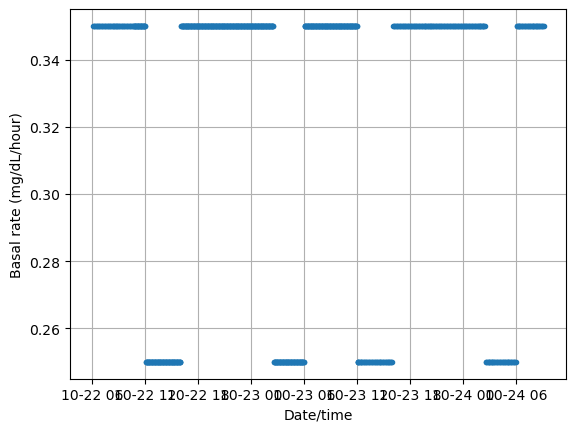

In [32]:
in_times = df_entries["time"].iloc[53700:]

basal = get_setting_at_times(in_times, col_profile, req_setting = "basal", req_profile = "Default")

plt.plot(in_times, basal,'.')
plt.xlabel('Date/time')
plt.ylabel('Basal rate (mg/dL/hour)')
plt.grid()

In [46]:
df_entries["time"] = pd.to_datetime(df_entries["dateString"])
in_times = df_entries["time"].iloc[53700:]

col_prof = col_profile
req_setting = "carbratio"
req_profile = "Default"

In [73]:

# ##### Prep time variables #####

# Convert in_times array to series (if it isn't already)
in_times = pd.Series(in_times)

# Convert requested input times to unix
in_times_unix = in_times.view('int64')

# Compute seconds elapsed in current day (to get at the current carb ratio)
seconds_in_day = in_times.dt.hour*3600 + in_times.dt.minute*60 + in_times.dt.second

# ##### Prep profile documents #####

# Dump every profile document into a list
prof_docs_all = [prof for prof in col_profile.find({})]

# Get all the time stamps and convert to unix time (nanoseconds)
prof_time_unix = [int(prof["mills"])*1e6 for prof in prof_docs_all]

# Get all the "store" items in each document
all_store = [doc["store"] for doc in prof_docs_all]

# Pull out all the keys for each "store" 
store_keys = [x.keys() for x in all_store]

# Extract the "store" info for each document, for any available profiles
all_store_vals = [[doc[key] for key in store_keys[doc_num]] for doc_num, doc in enumerate(all_store)]

# Extract the profile names for each document
all_store_profiles = [[key for key in store_keys[doc_num]] for doc_num, doc in enumerate(all_store)]

# ##### Next, figure out which profile is appropriate for each requested time #####

# Get the indices of the most "recent" documents from the collection. Only keep the ones for the requested profile.
doc_idx = [(len([in_time-t for t_idx, t in enumerate(prof_time_unix) if (in_time-t >= 0) & (req_profile in all_store_profiles[t_idx])]) - 1) for in_time in in_times_unix]

# Profile info for each requested time
requested_prof_info = [[all_store[this_doc][prof] for prof in all_store_profiles[this_doc] ] for this_doc in doc_idx]

val_req = []
for idx, prof_info in enumerate(requested_prof_info):
    if req_setting in prof_info[0].keys():
        carb_ratio = prof_info[0][req_setting]
    else: 
        raise Exception("The requested setting, " + req_setting + ", is not one of: " + ', '.join(list(prof_info[0].keys())))

    # Ensure that the input time zone (CGM) matches the profile/treatment time zone
    this_req_time_in = in_times.iloc[idx].tz_convert(prof_info[0]['timezone'])
    this_req_time = this_req_time_in.hour*3600 + this_req_time_in.minute*60 + this_req_time_in.second

    times = [int(cr["time"].split(':')[0])*3600 + int(cr["time"].split(':')[1])*60 for cr in carb_ratio]
    crs = [cr["value"] for cr in carb_ratio]

    t_diff = [this_req_time - t for t in times]

    val_req.append([crs[idx] for idx, x in enumerate(t_diff) if x>0][-1])




In [91]:
[int(cr["time"].split(':')[0])*3600 + int(cr["time"].split(':')[1])*60 for cr in carb_ratio]


[0, 19800, 39600, 57600, 72000]

In [53]:
test = in_times.iloc[idx]
test.tz_convert('US/Eastern')

Timestamp('2023-10-25 08:34:39-0400', tz='US/Eastern')

In [58]:
in_times.iloc[idx].tz_convert(prof_info[0]['timezone'])

Timestamp('2023-10-25 08:34:39-0400', tz='Etc/GMT+4')

In [61]:
seconds_in_day = this_req_time_in.hour*3600 + this_req_time_in.minute*60 + this_req_time_in.second
seconds_in_day

30879

In [60]:
this_req_time_in


Timestamp('2023-10-25 08:34:39-0400', tz='Etc/GMT+4')

In [62]:
8*3600

28800